# <center> LESSON 9: CASE STUDY with CREDIT SCORING </center>

## 1. PROBLEM

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

- **Input**: Historical data of 250,000 borrowers.
- **Output**: SeriousDlqin2yrs.
- **Goal**: Build a model that borrowers can use to help make the best financial decisions.

Reference: [Kaggle Dataset](https://www.kaggle.com/c/GiveMeSomeCredit)

## 2. Exploratory Data Analysis (EDA)

### 2.1 Variables descriptions

|Variables|Descriptions|
|-|-|
|**SeriousDlqin2yrs**| Person experienced 90 days past due delinquency or worse|
|**RevolvingUtilizationOfUnsecuredLines**| Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits|
|**age**| Age of borrower in years|
|**NumberOfTime30-59DaysPastDueNotWorse**| Number of times borrower has been 30-59 days past due but no worse in the last 2 years||
|**DebtRatio**| Monthly debt payments, alimony,living costs divided by monthy gross income
|**MonthlyIncome**| Monthly income|
|**NumberOfOpenCreditLinesAndLoans**| Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)|
|**NumberOfTimes90DaysLate**| Number of times borrower has been 90 days or more past due|
|**NumberRealEstateLoansOrLines**| Number of mortgage and real estate loans including home equity lines of credit|
|**NumberOfTime60-89DaysPastDueNotWorse**| Number of times borrower has been 60-89 days past due but no worse in the last 2 years|
|**NumberOfDependents**| Number of dependents in family excluding themselves (spouse, children etc.)|

### 2.2 Statistics

**Q1: Import necessary libraries: Pandas, Numpy, Matplotlib, Seaborn**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Q2: Load data using pd.read_csv()**

In [2]:
df_train = pd.read_csv('cs-training.csv')
df_test = pd.read_csv('cs-test.csv')

**Q3: Get the first 5 rows of train set**

**Q4: Get number of rows and columns of  train set**

**Q5: Describe the distribution of train set**

**Q6: Get information of train set by df.info()**

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

**Q7: Get the missing percent per columns of train set**

In [4]:
#sum(missing)/len(data)
df_train.isnull().sum()*100/len(df_train)

SeriousDlqin2yrs                         0.000000
RevolvingUtilizationOfUnsecuredLines     0.000000
age                                      0.000000
NumberOfTime30-59DaysPastDueNotWorse     0.000000
DebtRatio                                0.000000
MonthlyIncome                           19.820667
NumberOfOpenCreditLinesAndLoans          0.000000
NumberOfTimes90DaysLate                  0.000000
NumberRealEstateLoansOrLines             0.000000
NumberOfTime60-89DaysPastDueNotWorse     0.000000
NumberOfDependents                       2.616000
dtype: float64

### 2.3 Visualization

**Q8: Target disitribution on train set via bar chart**

In [5]:
df_train.SeriousDlqin2yrs.value_counts()*100/len(df_train)  #inbalanced data(DL chenh lech qua lon)

0    93.316
1     6.684
Name: SeriousDlqin2yrs, dtype: float64

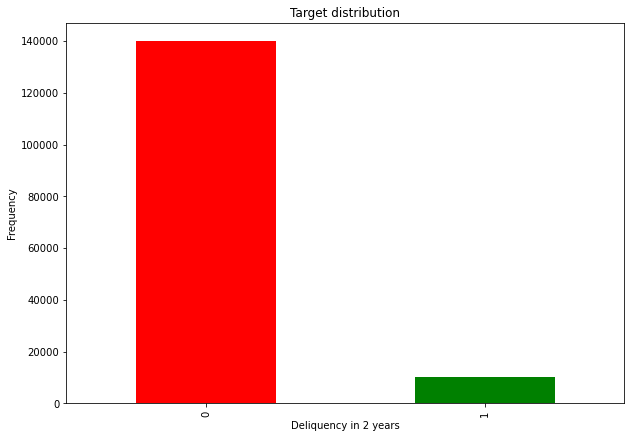

In [6]:
plt.figure(figsize=(10,7))

df_train.SeriousDlqin2yrs.value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Target distribution')
plt.xlabel('Deliquency in 2 years')
plt.ylabel('Frequency');

**Q9: Correlation of features and target** #tuong quan

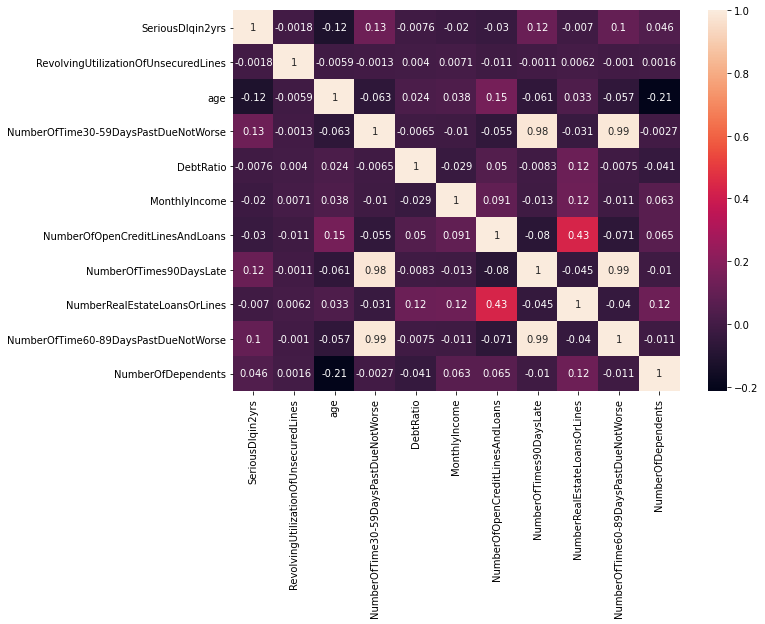

In [7]:
plt.figure(figsize=(10,7))
sns.heatmap(df_train.corr(), annot=True);  #.corr danh gia moi tuong quan

**Q10: Describe features distribution and correlation given histogram and pairplot chart** #mo ta phan bo dua tren histogram

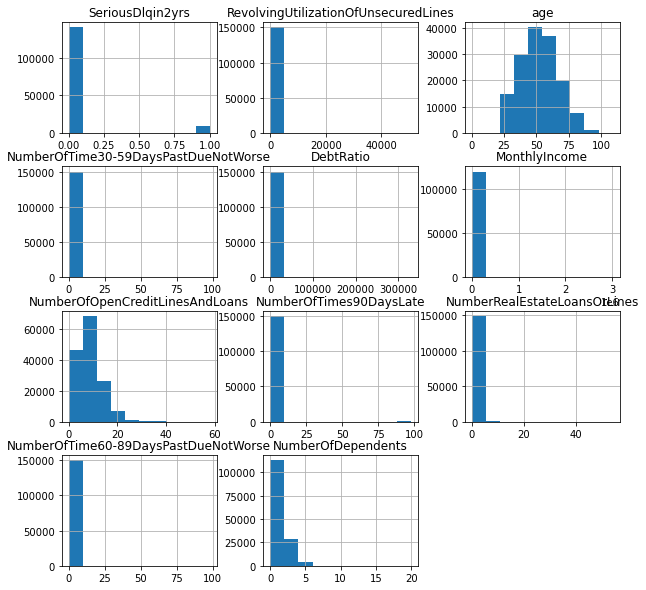

In [8]:

df_train.hist(figsize=(10,10));

**Q11: Explore each feature with target**  #

In [9]:
df_train.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [10]:
# sns.displot(df_train['RevolvingUtilizationOfUnsecuredLines']);

## 3. MODEL   # missing and outliers

**Q12: Handle outliers in dataset**

 Inter quantile range (**IQR**)(danh gia DL vaf lay DL trong khoang Q1, Q2, k lay phan long tail outlier)
     - Q1 + 1,5 * IQR < IQR < Q3 + 1,5 * IQR

![](https://upload.wikimedia.org/wikipedia/commons/8/89/Boxplot_vs_PDF.png)

In [34]:
from collections import Counter
def detect_outliers(df, n, features):
    
    """
    Input:
    df: DataFrame
    """
    outlier_indices = []
    #step1: iterate over features(columns)
    for col in features:
        #step2: Calculate 1st quantile (25%)
        Q1 = np.percentile(df[col], 25)
        #step3: Calculate 1st quantile (75%)
        Q3 = np.percentile(df[col], 75)
        #step4: Calculate IQR = 03-01
        IQR = Q3 - Q1
        #step5: Outlier stop : Q1-1.5*IQR <IQR<Q3-1.5*IQR
        outlier_step = 1.5 * IQR
        #step6: Determine a list of indices outlier for features(cols)
        outlier_list_col = df[(df[col]< Q1 - 1.5*IQR) | (df[col]> Q3+ 1.5*IQR)]
        #step7: Append 
        outlier_indices.extend(outlier_list_col)
        
   #Select rows containing more than n outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n) # Take k given v>n
        
    return multiple_outliers

    
    

In [30]:
df_train.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [37]:
features = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']
      
outliers_to_drop = detect_outliers(df_train, 2 , features)

In [38]:
len(df_train), len(outliers_to_drop)

(150000, 11)

**Q13: Merge train and test dataset**

In [ ]:
dataset = pd.concat{[df_train, df_test], axis = 0 }
dataset.info()

**Q14: Rename columns name into shorter alias**

In [ ]:
dataset.rename(columns = {'SeriousDlqin2yrs':'Target', 
                          'RevolvingUtilizationOfUnsecuredLines':'',
                          'age',
                            'NumberOfTime30-59DaysPastDueNotWorse',
                          'DebtRatio', 'MonthlyIncome',
                           'NumberOfOpenCreditLinesAndLoans',
                          'NumberOfTimes90DaysLate',
                           'NumberRealEstateLoansOrLines',
                          'NumberOfTime60-89DaysPastDueNotWorse',
                           'NumberOfDependents'
    
})

**Q15: Building binary/dummy variables**
**Hints**: Quantile data first
(tao ra bien binary/dummy variables)

In [ ]:
#  Co nen bien doi hay khong?, 
#  tai sao can bien doi bien nhu vay?


In [ ]:
data.UnsecLines

**Q16: Train test split**

**Q17: Train prediction model using Random Forest Classifier**

**Q18: Get feature importance from classifier**

**Q19: Retrain with better parameters**

**Q20: Predict and evaluate the model performance**

<center> <img src="https://media.makeameme.org/created/have-a-nice-17d2442086.jpg" width="500"/> </center>